<h2>Part 3</h2>

We assume testData.txt and trainData.txt are located in the same folder as this jupyter notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

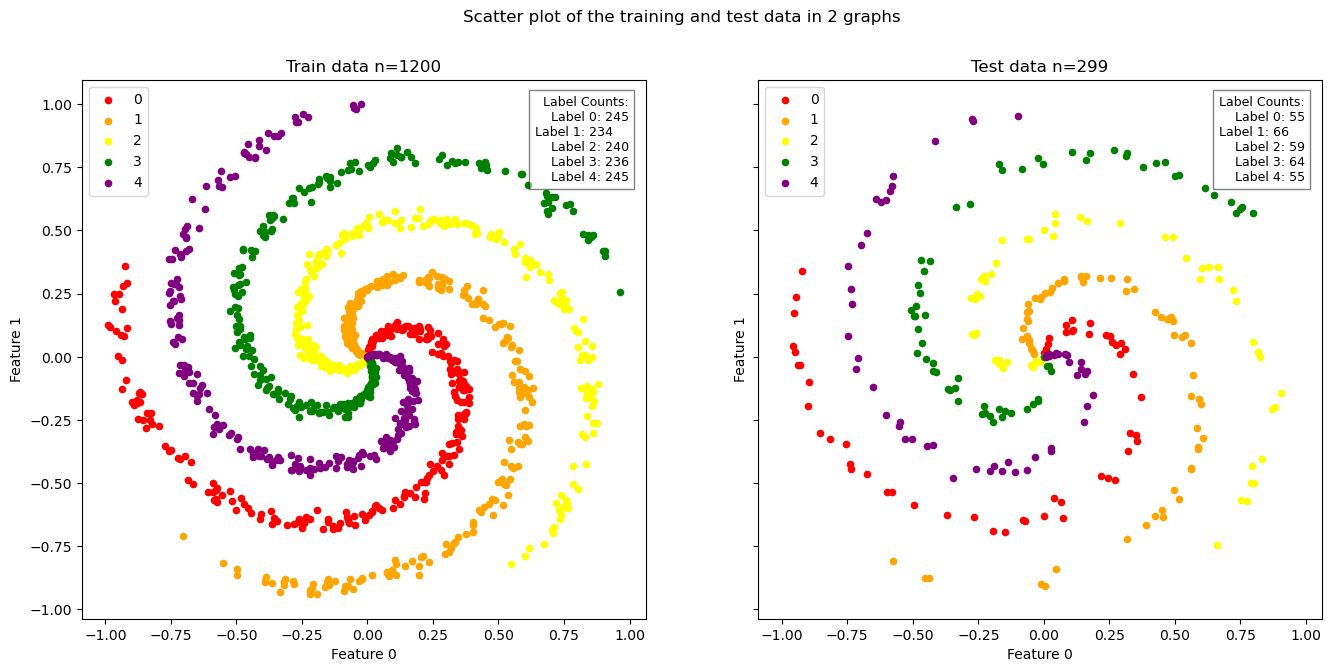

In [4]:
trainData = [] # (label, feature_0, feature_1)
testData = [] # same structure

# --- LOAD DATA FROM FILES ---
with open('trainData.txt') as i:
    lines = i.readlines()
    
    for line in lines:
        splitted = line.strip().split(" ")
        trainData.append(tuple(np.float64(x) for x in splitted))

with open('testData.txt') as i:
    lines = i.readlines()
    
    for line in lines:
        splitted = line.strip().split(" ")
        testData.append(tuple(np.float64(x) for x in splitted))
    
trainData = np.array(trainData)
testData = np.array(testData)

# --- INITIALIZE SEPARATE ARRAYS WITH DATA CATEGORIZED PER LABEL ------
train_per_label = [[], [], [], [], []]
test_per_label = [[], [], [], [], []]

for (label, f0, f1) in trainData:
    train_per_label[int(label)].append((f0, f1))

for (label, f0, f1) in testData:
    test_per_label[int(label)].append((f0, f1))

# Every label gets a color
colors = ['red', 'orange', 'yellow', 'green', 'purple']

# The figure will have 2 plots, one for training data and one for test data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Plot the train data per label
for i, l in enumerate(train_per_label):
    ax1.scatter([x for x,y in l], [y for x,y in l], color=colors[i], label=i, s=20)
    
# Plot the test data per label
for i, l in enumerate(test_per_label):
    ax2.scatter([x for x,y in l], [y for x,y in l], color=colors[i], label=i, s=20)
    
ax1.set_title(f"Train data n={len(trainData)}")
ax2.set_title(f"Test data n={len(testData)}")
ax1.legend()
ax2.legend()
ax1.set_xlabel("Feature 0")
ax1.set_ylabel("Feature 1")
ax2.set_xlabel("Feature 0")
ax2.set_ylabel("Feature 1")
plt.suptitle("Scatter plot of the training and test data in 2 graphs")

# ----------------- SETUP 'label counts' text box in plots (top right corner) ---------------------------
labels = trainData[:, 0] # all 
counts = [np.sum(labels == i) for i in range(5)]
info_text = f"Label Counts:\nLabel 0: {counts[0]}\nLabel 1: {counts[1]}\
    \nLabel 2: {counts[2]}\nLabel 3: {counts[3]}\nLabel 4: {counts[4]}"

ax1.text(
    0.97, 0.97,
    info_text,
    transform=ax1.transAxes,
    fontsize=9,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)

labels = testData[:, 0] # all 
counts = [np.sum(labels == i) for i in range(5)]
info_text = f"Label Counts:\nLabel 0: {counts[0]}\nLabel 1: {counts[1]}\
    \nLabel 2: {counts[2]}\nLabel 3: {counts[3]}\nLabel 4: {counts[4]}"

ax2.text(
    0.97, 0.97,  # x, y position in axes coordinates (0-1)
    info_text,
    transform=ax2.transAxes,
    fontsize=9,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)

plt.show()

In [5]:
# dependencies (some may already be imported earlier in this assignment, but we will keep everything together)
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from train_val_test_funcs import train_validate, test

In [6]:
# trainData, testData are numpy arrays and both have structure (label, feature0, feature1)
# we will make train and test datasets with proper target arrays
trainX = trainData[:, 1:]
testX = testData[:, 1:]
trainy = trainData[:, 0]
testy = testData[:, 0]

In [7]:
device = "cpu"

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer = nn.Linear(2, 8, bias=True)
        self.nextLayer = nn.Linear(8, 16, bias=True)
        self.nextLayer2 = nn.Linear(16, 32, bias=True)
        self.nextLayer3 = nn.Linear(32, 16, bias=True)
        self.lastLayer = nn.Linear(16, 5, bias=True)
        self.activationLayer = nn.ReLU()
        self.batchNorm16 = nn.BatchNorm1d(16)
        self.batchNorm32 = nn.BatchNorm1d(32)
    
    def forward(self, x):
        x = self.inputLayer(x)
        x = self.activationLayer(x)
        x = self.nextLayer(x)
        x = self.batchNorm16(x)
        x = self.activationLayer(x)
        x = self.nextLayer2(x)
        x = self.batchNorm32(x)
        x = self.activationLayer(x)
        x = self.nextLayer3(x)
        x = self.batchNorm16(x)
        x = self.activationLayer(x)
        x = self.lastLayer(x)
        
        return x

In [8]:
# ----------------------- SETUP the network for TRAINING -------------------------------------
learningRate = 0.0005

model = MLP().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=0.001)

loss_fn = nn.CrossEntropyLoss()

# --- IMPORTANT CONSTANTS THAT YOU CAN ACTUALLY TWEAK ---
# all_games (100%)
# ├─ no_test ((1-TEST_SPLIT) * 100%)
# │  ├─ training ((1-VALIDATION_SPLIT) * 100%)
# │  └─ validation (VALIDATION_SPLIT * 100%)
# └─ test (TEST_SPLIT * 100%)
VALIDATION_SPLIT = 0.15  # hence, will be a percentage of the no_test data

# As stated in slide 42 of lecture 11, make sure to use 'reduction='mean' for the loss function when comparing this hyperparameter
# If it is 'sum', a larger batch size automatically means a larger loss because there are more samples
BATCH_SIZE = 16

# This is to enable better hyperparameter tuning
SHUFFLE_SEED = 9999  

EPOCHS = 1000

# EARLY STOPPING
early_stop_counter = 0  # do not change
early_stop_best_loss = torch.inf
early_stop_best_model_state = None
PATIENCE = 100  # after how many epochs of no decrease in loss should we stop
DELTA = 1e-6  # if the loss decreases with maximum this delta, do not reset the counter

# Other hyperparameters
USE_LEARNING_RATE_SCHEDULER = False
if not USE_LEARNING_RATE_SCHEDULER:
    scheduler = None

USE_TOP_K_ACCURACY = True
K_ACCURACY = 3

# --- SETTING UP TRAINING / VALIDATION DATA ---
n_no_test = trainX.shape[0]
n_validation = int(n_no_test * VALIDATION_SPLIT)

# Shuffle
torch.manual_seed(SHUFFLE_SEED)
indices = torch.randperm(n_no_test)

# Split
validation_indices = indices[:n_validation]
train_indices = indices[n_validation:]

x_val, y_val = trainX[validation_indices], trainy[validation_indices]
x_train, y_train = trainX[train_indices], trainy[train_indices]

# Setup data loaders for given BATCH_SIZE
train_data = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(testX).float(), torch.tensor(testy).long())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# TODO visualizing the training data based on player / total number of moves or something similar

# --- TRAINING, VALIDATION ---
train_losses, val_losses = [], []

for iEpoch in range(EPOCHS):
    avg_train_loss, avg_val_loss \
        = train_validate(train_loader=train_loader, 
                        validation_loader=validation_loader,
                        model=model,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device,
                        scheduler=scheduler)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {iEpoch}:\
            \n<Insert accuracy function values here>\
            \nTraining loss {avg_train_loss:.3f}, Validation loss {avg_val_loss:.3f}")

    # -- EARLY STOPPING CHECK --
    if avg_val_loss < early_stop_best_loss - DELTA:
        # A better loss was found, so reset counter and save model state
        early_stop_best_loss = avg_val_loss
        early_stop_counter = 0
        # Save the best model so we can restore it later and get the best model performance to use the test data for.
        early_stop_best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping...")
    
            # Restore the best model which was saved earlier.
            model.load_state_dict(early_stop_best_model_state)
            break

# --- TESTING ---
avg_test_loss = test(test_loader=test_loader,
                     model=model,
                     loss_fn=loss_fn,
                     device=device)
print(f"\n<Insert accuracy function values here>\
        Test loss {avg_val_loss:.3f}")


tensor([[-0.0436,  0.2871, -0.1060,  0.3019,  0.3748],
        [-0.1171,  0.2663,  0.0566,  0.3932,  0.2585],
        [-0.1290,  0.3082,  0.0171,  0.4173,  0.3565],
        [-0.0919,  0.2984, -0.0489,  0.3642,  0.3823],
        [ 0.0898,  0.1513,  0.2829,  0.0741, -0.2821]]) tensor([1, 1, 4, 0, 3])
tensor([[ 0.0102,  0.1745,  0.2387,  0.1186, -0.2134],
        [-0.1198,  0.3066,  0.0150,  0.4081,  0.3400],
        [-0.0211,  0.2464,  0.0156,  0.2760,  0.2805],
        [-0.0890,  0.1685,  0.1537,  0.2320,  0.0732],
        [-0.1893,  0.2959,  0.0959,  0.4852,  0.3459]]) tensor([2, 4, 1, 2, 2])
tensor([[ 0.0898,  0.1433,  0.2929,  0.0790, -0.2749],
        [-0.0143,  0.1692,  0.2059,  0.1235,  0.0250],
        [-0.2588,  0.2734,  0.1719,  0.5303,  0.4260],
        [-0.1656,  0.3052,  0.0625,  0.4601,  0.3628],
        [-0.1132,  0.2966,  0.0188,  0.3985,  0.3201]]) tensor([3, 3, 3, 3, 4])
tensor([[-0.1310,  0.1377,  0.2504,  0.2302,  0.1013],
        [-0.2656,  0.1289,  0.3527,  0.4284, 

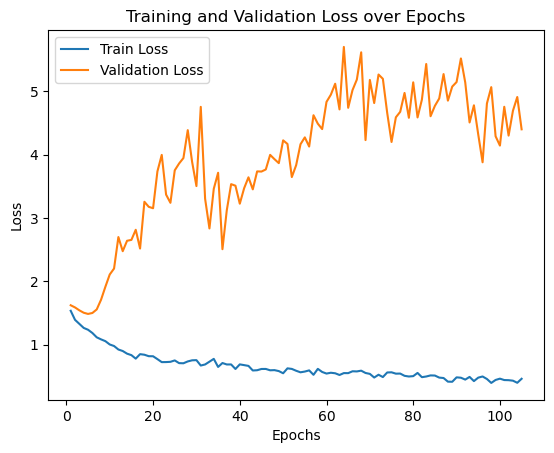

In [ ]:
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

In [ ]:
# ----------------------- TEST the performance -------------------------------------
# Since we have a small number of data points to test, we do not use batches
X, y = testData[:]
X, y = X.to(device), y.to(device)

model.eval()
with torch.no_grad():
    test_pred = model(X)
    test_loss = loss_func(test_pred, y).item()
    correct = (test_pred.argmax(1) == y).type(torch.float).sum().item()
    
accuracy = correct / len(testData)
print(f"------ RESULT ON TEST DATA ---------\nLoss: {test_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%")

ValueError: too many values to unpack (expected 2)

<h5>Describe results</h5>

I do not use batches to test the data, as we only have N=299 data points. With the current model and training strategy we get accuracies from 98-99.5%, depending on how the data is divided and shuffled. This result is a pretty average result of the models performance. Also see the graphs of the accuracy and loss on the training and validation set. After about 40 epochs the accuracy and loss only get better slightly, because of the lower learning rate and Adam's weight decay regularization parameter.

See the plot below for a visualization of the boundaries that the model decided on after training. I inceased the resolution from 30x30 to 500x500, since I really want to show how the model is well equipped in the 'outlier' regions (where the data points are quite a lot outside of the mean). I also changed the colors. Notice that the points that were not classified correctly, lie in the centre of the spiral.

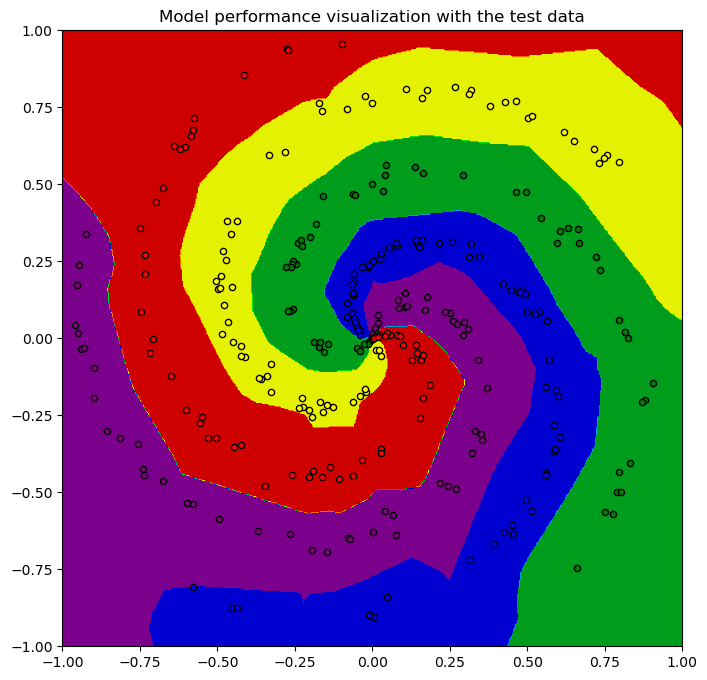

In [ ]:
model.cpu()
dim = 500
x,y=np.meshgrid(np.linspace(-1,1,dim),np.linspace(-1,1,dim))
xy=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
z=model(torch.tensor(xy).float()).detach().numpy()
z=np.argmax(z,1).reshape(dim,dim)
plt.figure(figsize=(8, 8))
plt.contourf(x,y,z, cmap='nipy_spectral')
# Plot the test data per label
colors = ['purple', 'blue', 'green', 'yellow', 'red']

for i, l in enumerate(test_per_label):
    plt.scatter([x for x,y in l], [y for x,y in l], color=colors[i], edgecolors='k', label=i, s=20)
    
plt.title("Model performance visualization with the test data")

plt.show()